### Projeto: Otimização de Cadeias de Suprimentos com Modelagem de Séries Temporais

In [62]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure
import statsmodels as sts
import sklearn as sk
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Imports para análise de dados
import scipy
from scipy.stats import boxcox
import warnings

In [2]:
# Carrega dataset
df = pd.read_csv('dataset.csv')

Analise Exploratoria

In [3]:
df.head()

,data,demanda_insumos_kg
0,2023-01-01,99.708762
1,2023-01-02,98.475161
2,2023-01-03,98.714361
3,2023-01-04,99.238156
4,2023-01-05,101.608597


In [4]:
df.dtypes

data                   object
demanda_insumos_kg    float64
dtype: object

In [6]:
# Converte Data como DateTime
df['data'] = pd.to_datetime(df['data'], format='mixed')
                            #format='%Y-%m')

In [7]:
df.dtypes

data                  datetime64[ns]
demanda_insumos_kg           float64
dtype: object

In [8]:
df

,data,demanda_insumos_kg
0,2023-01-01,99.708762
1,2023-01-02,98.475161
2,2023-01-03,98.714361
3,2023-01-04,99.238156
4,2023-01-05,101.608597
...,...,...
726,2024-12-27,138.491737
727,2024-12-28,137.528450
728,2024-12-29,136.367028
729,2024-12-30,135.440340


In [9]:
# Data como Index
df.index = df['data']

In [10]:
df.head()

,data,demanda_insumos_kg
data,,
2023-01-01,2023-01-01,99.708762
2023-01-02,2023-01-02,98.475161
2023-01-03,2023-01-03,98.714361
2023-01-04,2023-01-04,99.238156
2023-01-05,2023-01-05,101.608597


In [11]:
# Drop colum data
df.drop('data', axis=1, inplace=True)

In [12]:
df.head()

,demanda_insumos_kg
data,
2023-01-01,99.708762
2023-01-02,98.475161
2023-01-03,98.714361
2023-01-04,99.238156
2023-01-05,101.608597


In [13]:
df.isnull().sum()

demanda_insumos_kg    0
dtype: int64

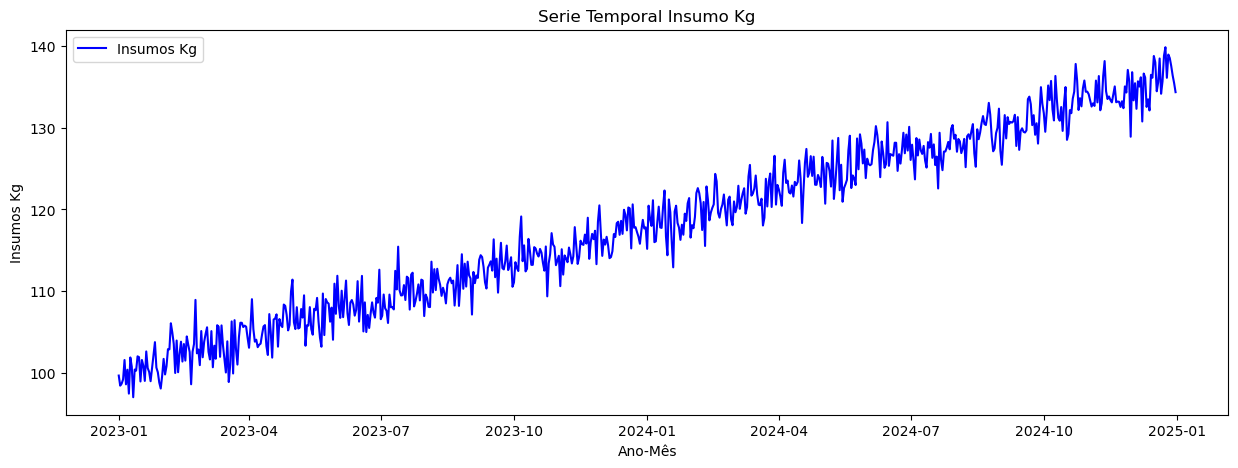

In [14]:
# Plot
figure(figsize = (15, 5))
plt.title("Serie Temporal Insumo Kg")
plt.plot(df, label = "Insumos Kg", color = 'blue')
plt.xlabel("Ano-Mês")
plt.ylabel("Insumos Kg")
plt.legend(loc = "best")
plt.show();

In [ ]:
target = df['demanda_insumos_kg']

In [15]:
# Período completo
print('Início do Período de Tempo: {}\nFinal do Período de Tempo: {}'.format(df.index.min(), df.index.max()))

Início do Período de Tempo: 2023-01-01 00:00:00
Final do Período de Tempo: 2024-12-31 00:00:00


In [16]:
df.describe()

,demanda_insumos_kg
count,731.000000
mean,118.057784
std,10.663148
min,97.061685
25%,108.936372
50%,117.820828
75%,127.200108
max,139.818436


### Grafico de Densidade

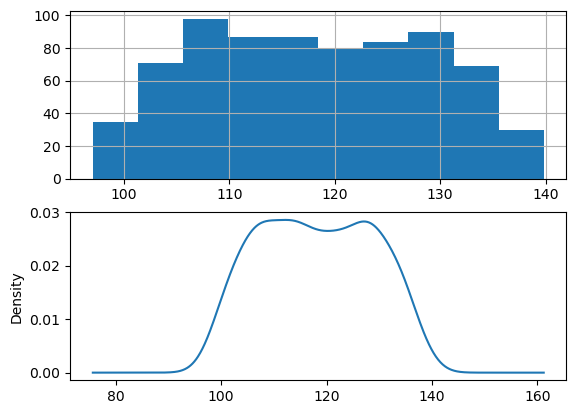

In [17]:
# Gráfico de Densidade

# Plot
plt.figure(1)

# Subplot 1
plt.subplot(211)
df.demanda_insumos_kg.hist()

# Subplot 2
plt.subplot(212)
df.demanda_insumos_kg.plot(kind = 'kde')
plt.show()

Análise Histograma e Densidade:
    
- A distribuição é gaussiana (distribuição normal).
- O que indica que não será necessário transformação pré-processamento da modelagem.

### Gráfico Box Plot Anual

Text(0, 0.5, '\nDemanda Insumos Kg')

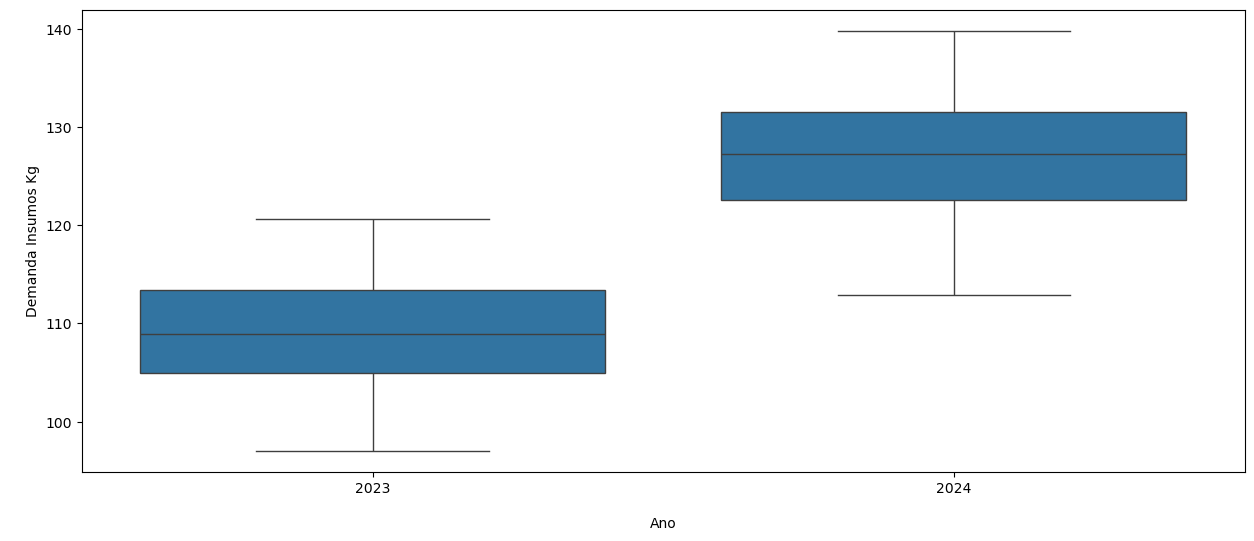

In [18]:

fig, ax = plt.subplots(figsize = (15,6))

# Define as variáveis
indice_ano = df.demanda_insumos_kg.index.year
valor = df.demanda_insumos_kg

# Cria um box plot para cada ano usando o Seaborn
# Observe que estamos extraindo o ano (year) do índice da série
sns.boxplot(x = indice_ano, y = valor, ax = ax, data = df)

plt.xlabel("\nAno")
plt.ylabel("\nDemanda Insumos Kg")

Análise do Box Plot

- Observado o aumento da mediana ao longo dos anos confirma uma tendência ascendente, e existe padrão da dispersão da mediana, e também mantem-se o tamanho das caixas.

### Decomposição da Série Temporal

In [19]:
# Decomposição
decompose_mult = seasonal_decompose(df, model='multiplicative', period=7)

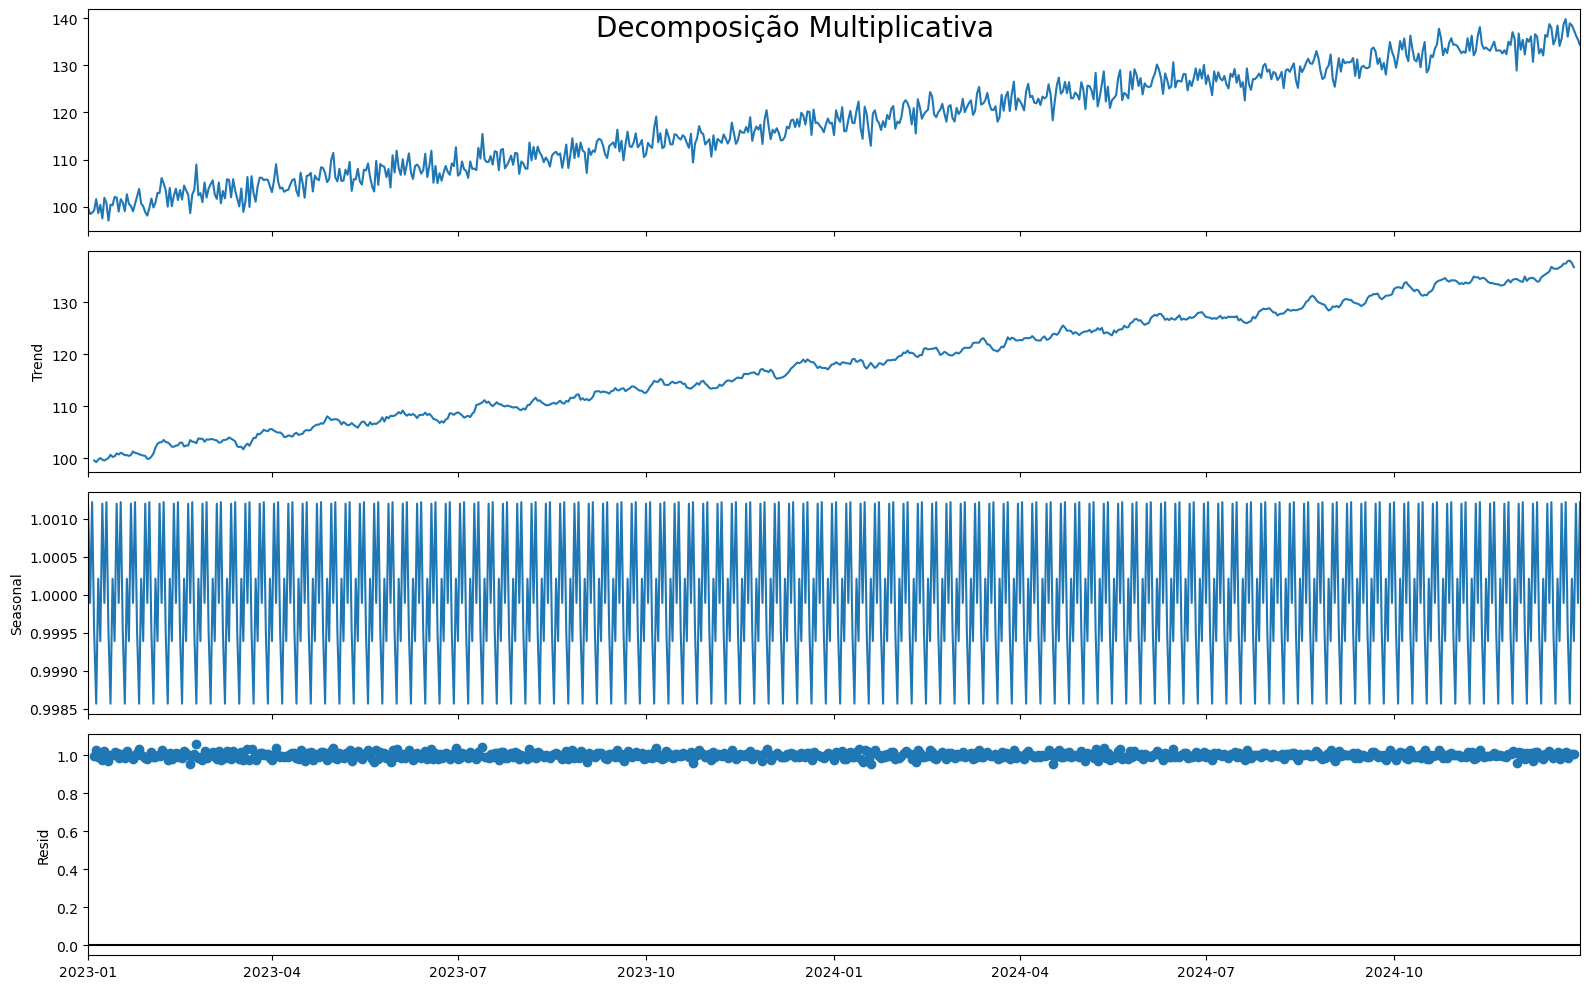

In [48]:
# Plot
plt.rcParams.update({'figure.figsize': (16,10)})
#figure(figsize = (15, 6))
#plt.rcParams.update({'figure.figsize': (16,10)})
decompose_mult.plot().suptitle('Decomposição Multiplicativa', fontsize = 20)
plt.show()

In [24]:
# Decomposição
decompose_adt = seasonal_decompose(df, model='add', period=7)

In [ ]:
#extrapolate_trend = 'freq'

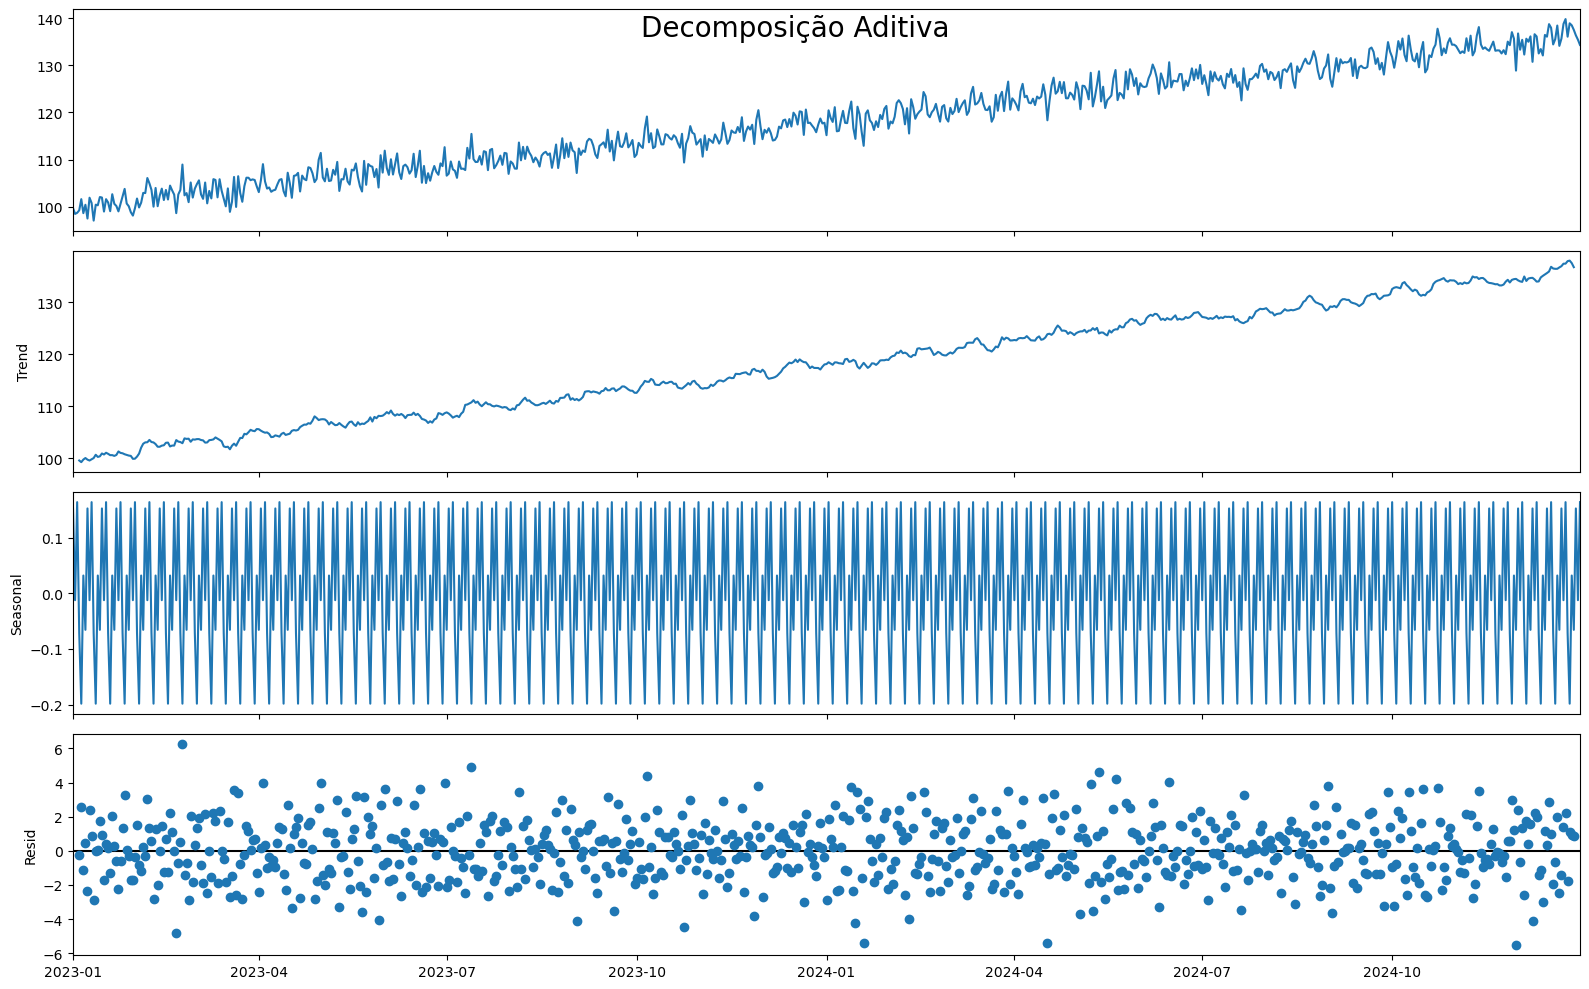

In [47]:
# Plot
plt.rcParams.update({'figure.figsize': (16,10)})
#figure(figsize = (15, 6))
#plt.rcParams.update({'figure.figsize': (16,10)})
decompose_adt.plot().suptitle('Decomposição Aditiva', fontsize = 20)
plt.show()

### Análise da Decomposição:

1 - Dados observados: Demanda por Insumos Kg

2 - Tendência: a decomposição mostrou claramente linha de tendência positiva.

3 - Sazonalidade: a decomposição mostrou que existe um fator de sazonalidade com picos de aumento e queda, que pode ser explicado com eventos sazonais (calendário) na demanda.

4 - Resíduos: mostrou que na decomposição aditiva existe um padrão, e na decomposição multiplicativa a irregularidade é aleatória, o que é preferível para modelagem.

#### Extração dos Componentes da Decomposição
Regra de extração:

**Valores Reais = (sazonal * tendência * resíduo)**

In [29]:
# Concatena o resultado da decomposição da série
df_reconstruida = pd.concat([decompose_mult.seasonal, 
                                      decompose_mult.trend, 
                                      decompose_mult.resid, 
                                      decompose_mult.observed], axis = 1)

In [30]:
# Define o nome das colunas
df_reconstruida.columns = ['Sazonalidade', 'Tendência', 'Resíduos', 'Valores_Observados']

In [31]:
# Mostra o resultado
df_reconstruida.head()

,Sazonalidade,Tendência,Resíduos,Valores_Observados
data,,,,
2023-01-01,1.001199,NaN,NaN,99.708762
2023-01-02,0.999894,NaN,NaN,98.475161
2023-01-03,1.001220,NaN,NaN,98.714361
2023-01-04,0.999513,99.543354,0.997420,99.238156
2023-01-05,0.998569,99.228040,1.025458,101.608597


In [32]:
# 💾 Salva a decomposição em arquivos CSV
decompose_mult.trend.to_csv('dados/01-trend.csv')
decompose_mult.seasonal.to_csv('dados/02-seasonal.csv')
decompose_mult.resid.to_csv('dados/03-residual.csv')


In [33]:
type(df)

pandas.core.frame.DataFrame

### Plots da Função de Autocorrelação (ACF) e Função de Autocorrelação Parcial (PACF)

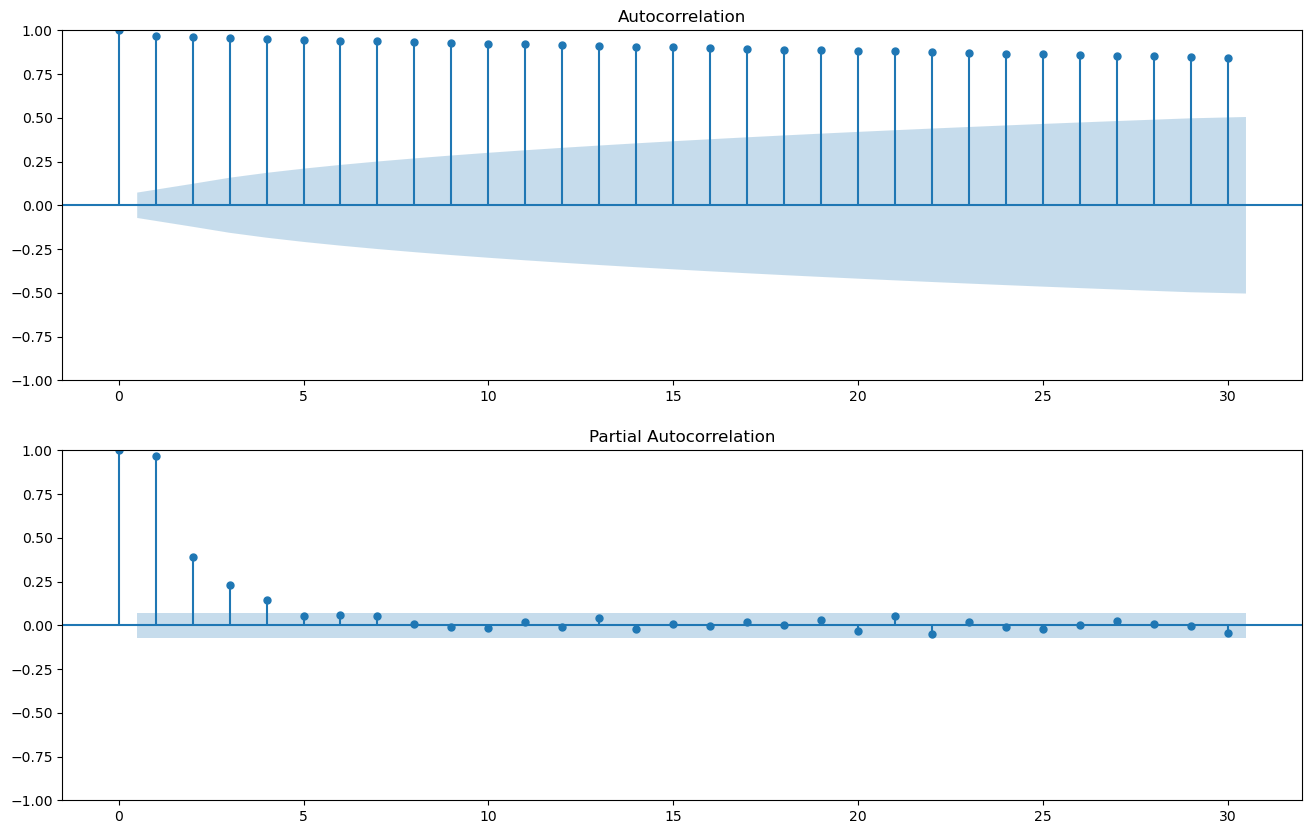

In [46]:
# Plots
plt.rcParams.update({'figure.figsize': (16,10)})

# Plot do gráfico ACF
plt.subplot(211)
plot_acf(df.demanda_insumos_kg, ax = plt.gca(), lags = 30)

# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(df.demanda_insumos_kg, ax = plt.gca(), lags = 30, method = 'ywm')
plt.show()


Análise ACF e PACF:
 
 - Indica ...

#### Teste Estatístico Dickey Fuller

Estas são as hipóteses do teste:

- Hipótese Nula (H0): A série temporal não é estacionária.
- Hipótese Alternativa (H1): A série temporal é estacionária.

In [49]:
# Função para testar a estacionaridade (Dickey Fullher)
def testa_estacionaridade(serie, window = 12, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

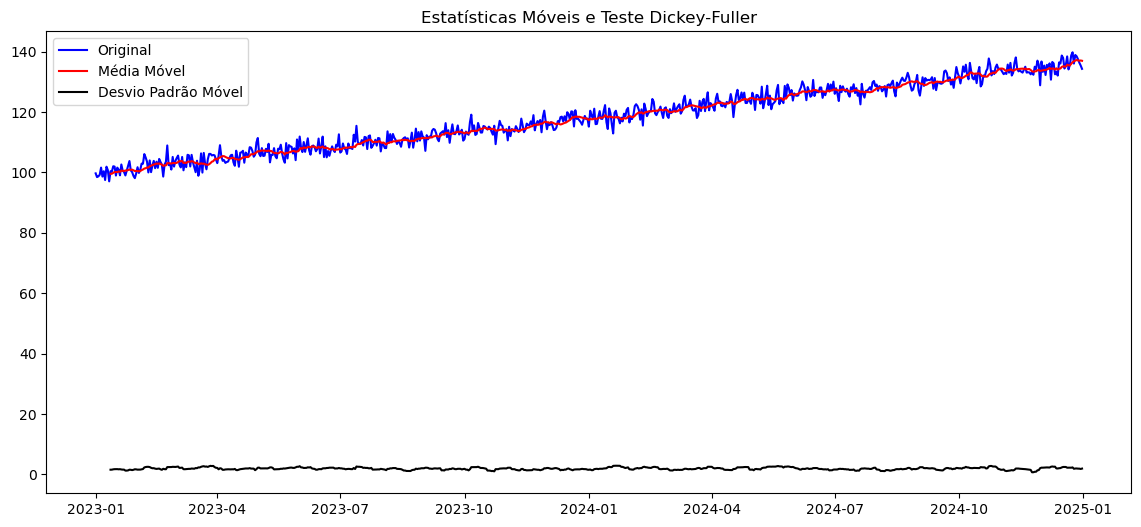


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.030946
Valor-p                           0.955897
Número de Lags Consideradas      20.000000
Número de Observações Usadas    710.000000
Valor Crítico (1%)               -3.439594
Valor Crítico (5%)               -2.865619
Valor Crítico (10%)              -2.568942
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [50]:
testa_estacionaridade(df)

Análise:

- O Valor-p é maior que 0.05. Não temos evidências estatísticas para rejeitar a hipótese nula de que a série não é estacionária. Logo, podemos concluir que a série NÃO é estacionária.

#### Transformação em Série Estacionária

In [51]:
# Aplicando Transformação Box-Cox
df['demanda_insumos_kg_Boxcox'] = boxcox(df['demanda_insumos_kg'], lmbda = 0.0)

In [52]:
df

,demanda_insumos_kg,demanda_insumos_kg_Boxcox
data,,
2023-01-01,99.708762,4.602254
2023-01-02,98.475161,4.589804
2023-01-03,98.714361,4.592230
2023-01-04,99.238156,4.597523
2023-01-05,101.608597,4.621128
...,...,...
2024-12-27,138.491737,4.930811
2024-12-28,137.528450,4.923831
2024-12-29,136.367028,4.915350


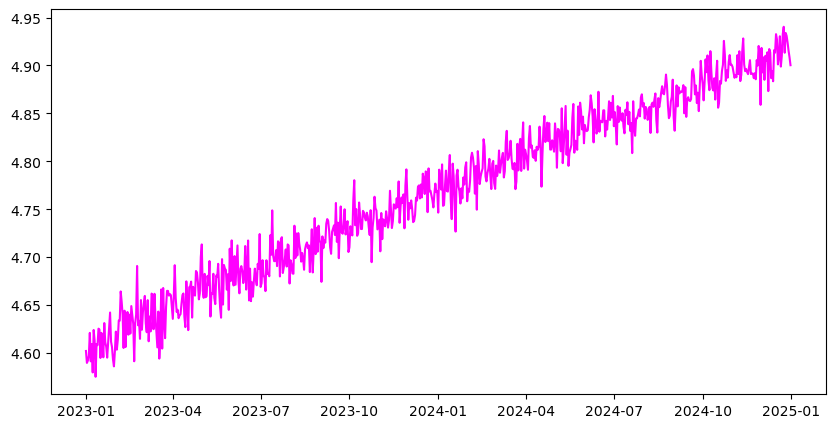

In [55]:
# Plot da série transformada
plt.figure(figsize = (10, 5))
plt.plot(df['demanda_insumos_kg_Boxcox'], color = "magenta")
plt.show()

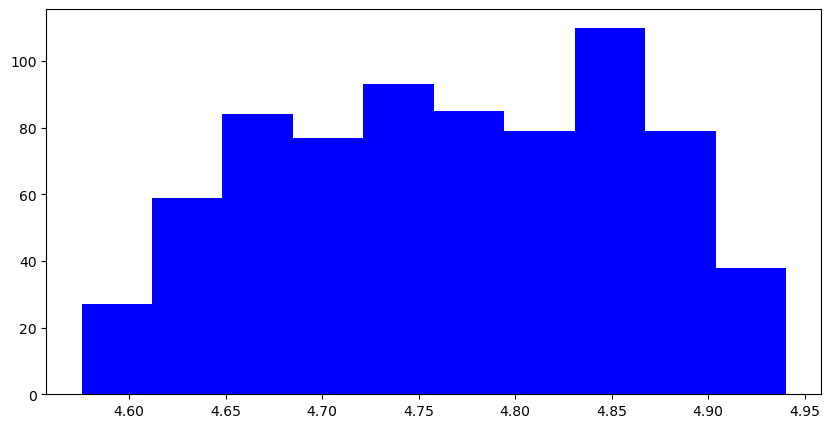

In [57]:
# Histograma
plt.figure(figsize = (10, 5))
plt.hist(df['demanda_insumos_kg_Boxcox'], color = "blue")
plt.show()

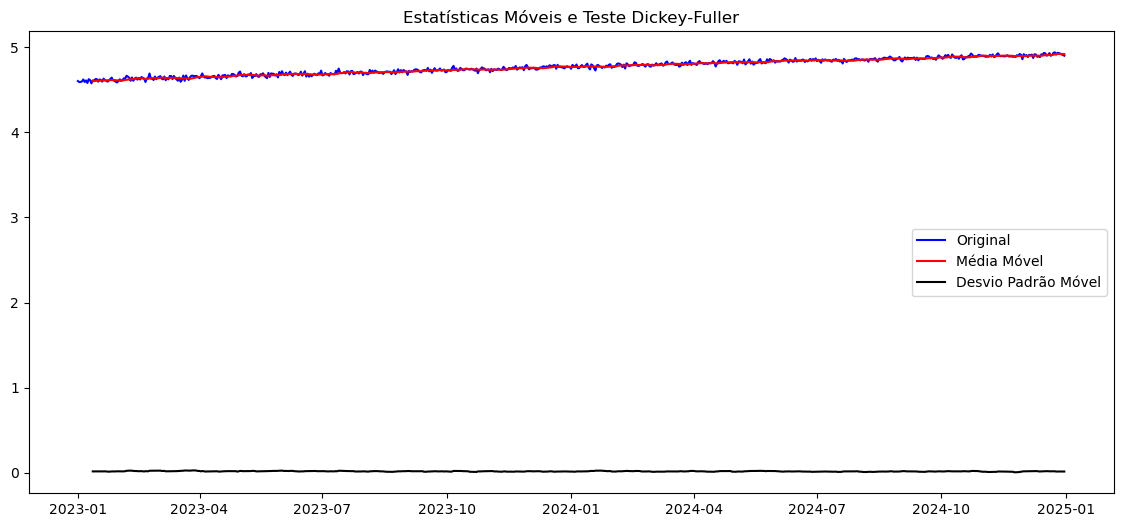


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.663866
Valor-p                           0.855889
Número de Lags Consideradas      20.000000
Número de Observações Usadas    710.000000
Valor Crítico (1%)               -3.439594
Valor Crítico (5%)               -2.865619
Valor Crítico (10%)              -2.568942
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [58]:
testa_estacionaridade(df['demanda_insumos_kg_Boxcox'])

Podemos definir o parâmetro lambda como None (o padrão) e deixar a função encontrar um valor ajustado estatisticamente.

In [53]:
# Aplicando Transformação Box-Cox
df['demanda_insumos_kg_Boxcox_2'], lam_value = boxcox(df['demanda_insumos_kg'])
print('Valor Ideal de Lambda: %f' % lam_value)
df.head()

Valor Ideal de Lambda: 0.649971


,demanda_insumos_kg,demanda_insumos_kg_Boxcox,demanda_insumos_kg_Boxcox_2
data,,,
2023-01-01,99.708762,4.602254,29.096974
2023-01-02,98.475161,4.589804,28.850084
2023-01-03,98.714361,4.592230,28.898041
2023-01-04,99.238156,4.597523,29.002915
2023-01-05,101.608597,4.621128,29.475124


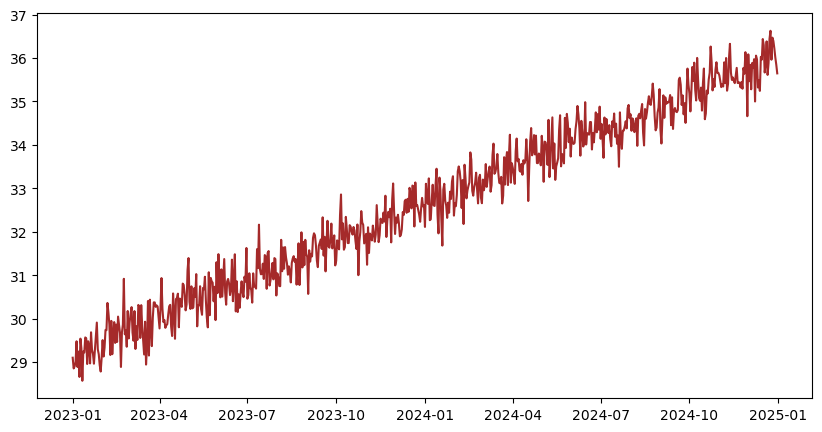

In [54]:
# Plot da série transformada
plt.figure(figsize = (10, 5))
plt.plot(df['demanda_insumos_kg_Boxcox_2'], color = "brown")
plt.show()

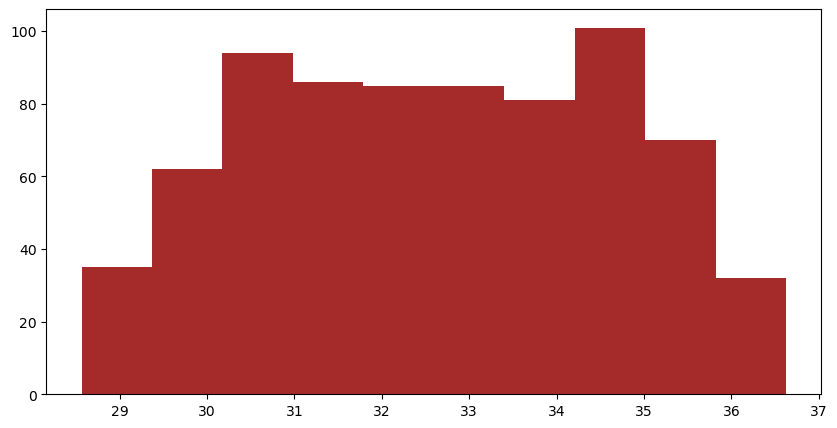

In [56]:
# Histograma
plt.figure(figsize = (10, 5))
plt.hist(df['demanda_insumos_kg_Boxcox_2'], color = "brown")
plt.show()

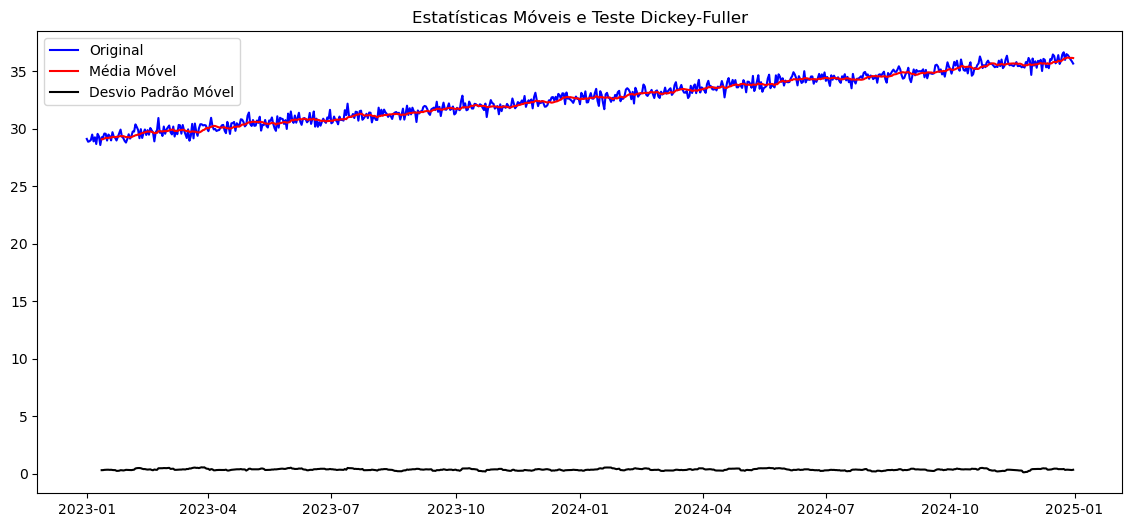


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.255121
Valor-p                           0.931624
Número de Lags Consideradas      20.000000
Número de Observações Usadas    710.000000
Valor Crítico (1%)               -3.439594
Valor Crítico (5%)               -2.865619
Valor Crítico (10%)              -2.568942
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [59]:
testa_estacionaridade(df['demanda_insumos_kg_Boxcox_2'])

In [69]:
df_series = df['demanda_insumos_kg'].copy()

In [70]:
df_series

data
2023-01-01     99.708762
2023-01-02     98.475161
2023-01-03     98.714361
2023-01-04     99.238156
2023-01-05    101.608597
                 ...    
2024-12-27    138.491737
2024-12-28    137.528450
2024-12-29    136.367028
2024-12-30    135.440340
2024-12-31    134.328530
Name: demanda_insumos_kg, Length: 731, dtype: float64

Poderia-se utilizar Médias Moveis, Suavização Exponencial para tentar transformar a série em estacionária.


A seguir a tentativa com Diferenciação.

In [61]:
# Função para diferenciação:
def diffFunc(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

In [71]:
# Colocando os dados na mesma escala
df_log = np.log(df_series)

In [72]:
df_log

data
2023-01-01    4.602254
2023-01-02    4.589804
2023-01-03    4.592230
2023-01-04    4.597523
2023-01-05    4.621128
                ...   
2024-12-27    4.930811
2024-12-28    4.923831
2024-12-29    4.915350
2024-12-30    4.908531
2024-12-31    4.900289
Name: demanda_insumos_kg, Length: 731, dtype: float64

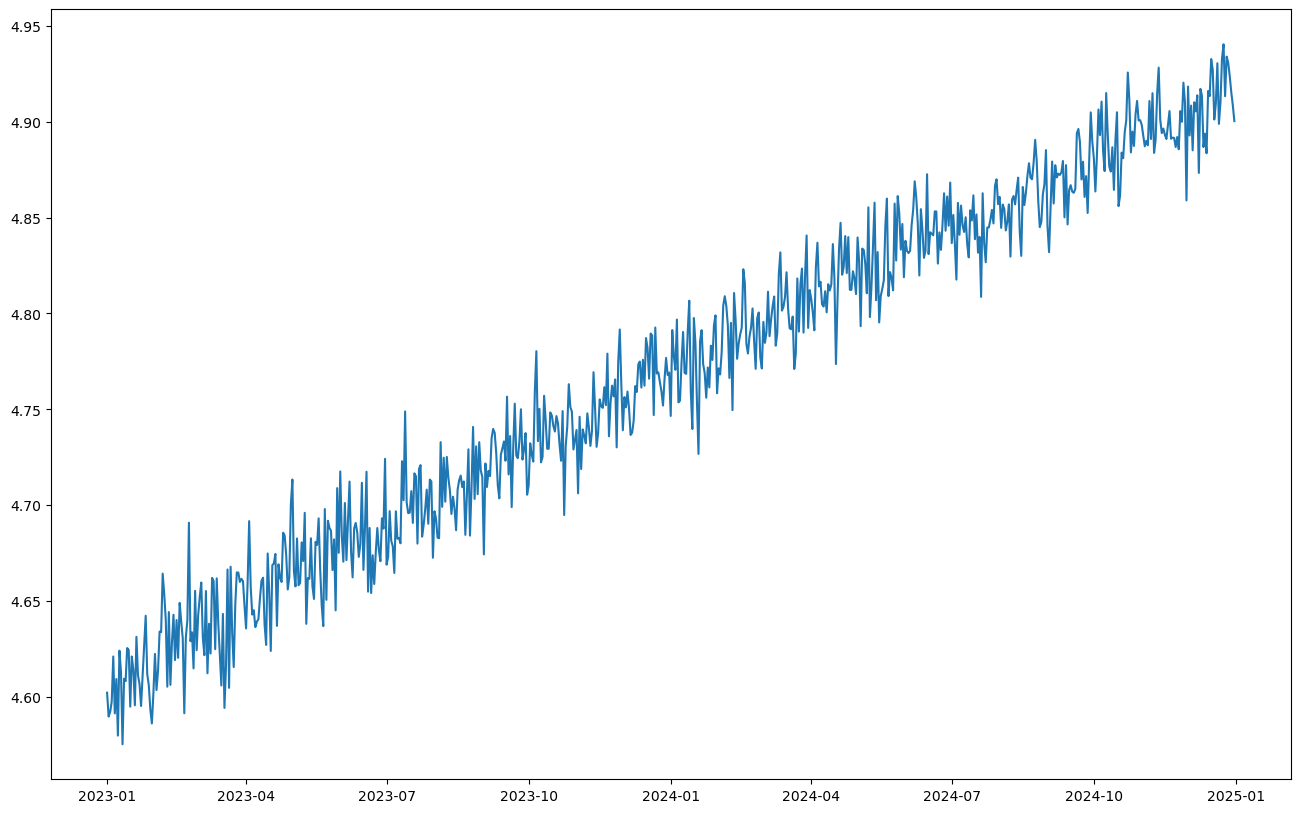

In [73]:
plt.plot(df_log)

In [77]:
type(df_log)

pandas.core.series.Series

In [83]:
diff_df_log = diffFunc(df_log)

C:\Users\User\AppData\Local\Temp\ipykernel_28932\1033780861.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = dataset[i] - dataset[i - interval]


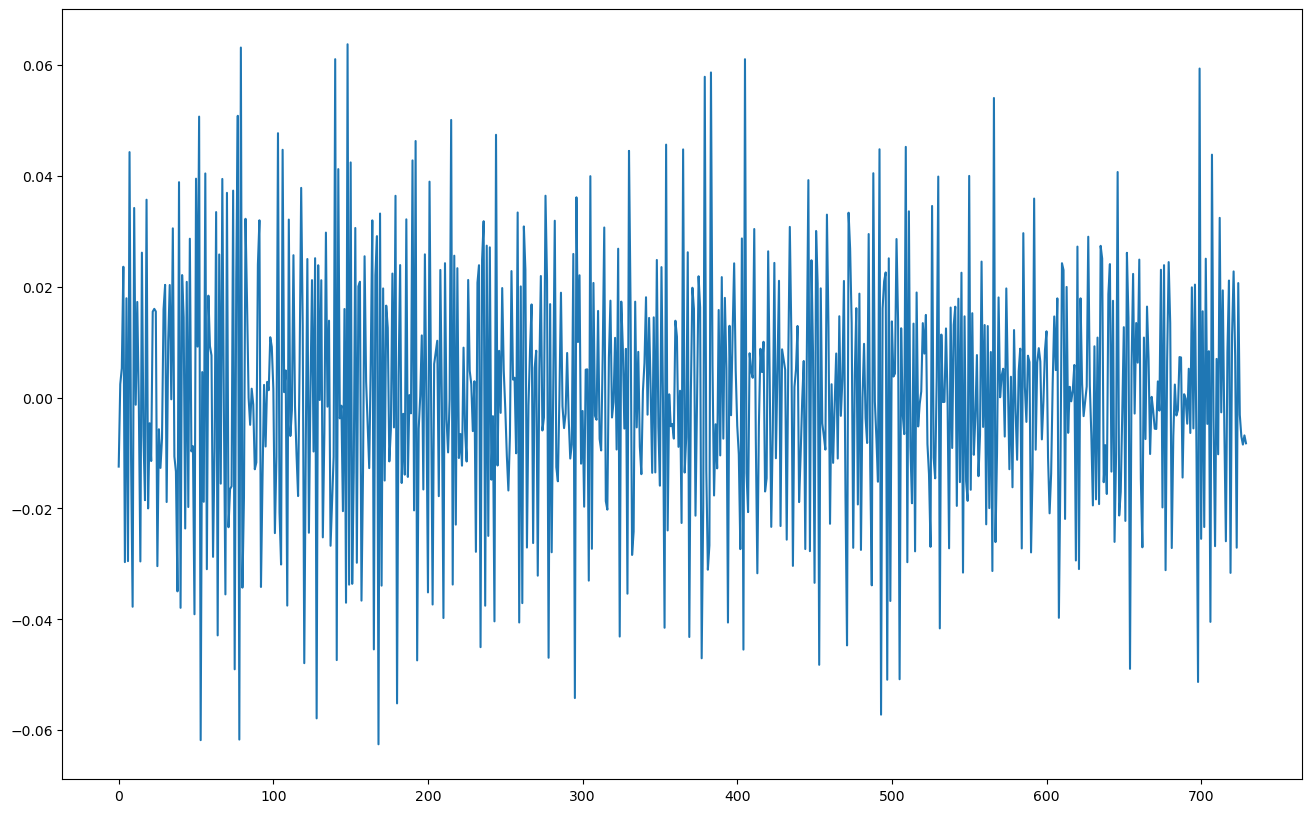

In [84]:
plt.plot(diff_df_log)

In [85]:
# Converte em dataframe, a lista gerada ao aplicar a diferenciação
convert_diff_df_log = pd.DataFrame(diff_df_log) 

In [86]:
type(convert_diff_df_log)

pandas.core.frame.DataFrame

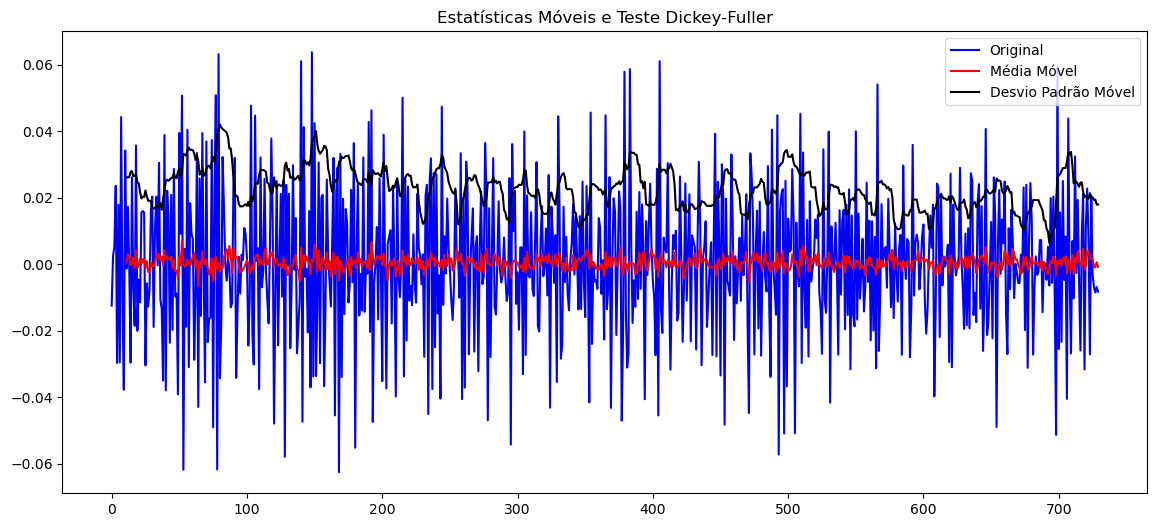


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -1.030585e+01
Valor-p                         3.280591e-18
Número de Lags Consideradas     1.900000e+01
Número de Observações Usadas    7.100000e+02
Valor Crítico (1%)             -3.439594e+00
Valor Crítico (5%)             -2.865619e+00
Valor Crítico (10%)            -2.568942e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [87]:
testa_estacionaridade(convert_diff_df_log)

#### Pré-Processamento

In [102]:
df_series

data
2023-01-01     99.708762
2023-01-02     98.475161
2023-01-03     98.714361
2023-01-04     99.238156
2023-01-05    101.608597
                 ...    
2024-12-27    138.491737
2024-12-28    137.528450
2024-12-29    136.367028
2024-12-30    135.440340
2024-12-31    134.328530
Name: demanda_insumos_kg, Length: 731, dtype: float64

In [112]:
type(df_series)

pandas.core.series.Series

In [103]:
df_series.shape

(731,)

In [104]:
# Divide Dados de Treino e Teste
df_treino = df_series.iloc[0:585]
df_valid = df_series.iloc[586:]

In [105]:
df_treino.shape

(585,)

In [107]:
df_valid.shape

(145,)

In [114]:
# Aplicando transformação de log (colocando os dados na mesma escala, o que é requerido pelos modelos ARIMA)
df_treino_log = np.log(df_treino) 

OBS: Esse dataset 'df_log' não precisa da transformação de log (colocando os dados na mesma escala, que é requerido pelos modelos ARIMA) pois já foi trasnformado anteriormente do dataset 'df_series' copia do 'df' original.

#### Forecasting - Série Temporais

#### Modelo ARIMA

In [115]:
# Cria o Modelo ARIMA

# Definimos:

# p = 2
# d = 1
# q = 0

# Modelo
modelo_AR = ARIMA(df_treino_log, order = (2, 1, 0))

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [116]:
# Treinamento
modelo_v1 = modelo_AR.fit() 

In [117]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino
previsoes_v1 = modelo_v1.fittedvalues

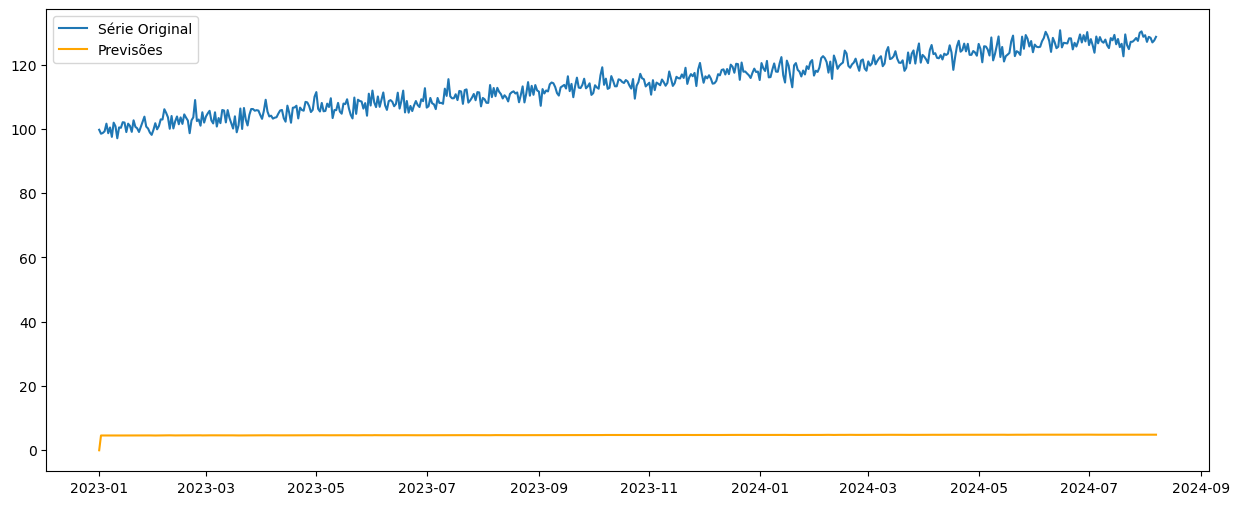

In [118]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v1, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [119]:
# Sumário do Modelo 
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     demanda_insumos_kg   No. Observations:                  585
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1470.429
Date:                qui, 03 jul 2025   AIC                          -2934.858
Time:                        16:15:16   BIC                          -2921.748
Sample:                    01-01-2023   HQIC                         -2929.748
                         - 08-07-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6312      0.038    -16.653      0.000      -0.705      -0.557
ar.L2         -0.3282      0.036     -9.127      0.000      -0.399      -0.258
sigma2         0.0004   2.36e-05     16.081      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   4.32   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.04   Prob(JB):                         0.66
Heteroskedasticity (H):               0.66   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Aqui está uma interpretação dos resultados:

Modelo: ARIMA(2,1,0) indica que o modelo é um processo autorregressivo de segunda ordem (AR(2)) com uma diferenciação (I(1)) e sem parte de médias móveis (MA(0)).

Parâmetros AR:

- ar.L1: O coeficiente do primeiro termo autorregressivo é -0.6312, o que significa que há uma relação negativa entre o valor atual da série e o valor imediatamente anterior.
- ar.L2: O coeficiente do segundo termo autorregressivo é -0.3282, indicando uma relação negativa mais fraca com o segundo valor anterior.
- Variância do erro (sigma2): O valor de 0.1610 indica a variância dos erros do modelo. Quanto menor esse valor, melhor o ajuste do modelo aos dados.

Testes Estatísticos:

- Ljung-Box (Q): O teste Ljung-Box verifica a autocorrelação residual. Um valor de p (Prob(Q)) próximo de 1, como 4.32 aqui, sugere que não há evidências significativas de autocorrelação residual, indicando um bom ajuste do modelo.
- Jarque-Bera (JB): Este teste verifica a normalidade dos resíduos. Um valor de p (Prob(JB)) próximo de 0, como aqui 0.84, indica que os resíduos não são normalmente distribuídos. Isso pode ser uma preocupação e pode valer a pena investigar mais.
- Heteroskedasticity (H): Este teste verifica a homocedasticidade dos resíduos. Um valor de p (Prob(H)) próximo de 0, 0.66, indica que há evidências de heterocedasticidade, o que significa que a variância dos resíduos não é constante ao longo do tempo.

Medidas de ajuste:

- AIC (Akaike Information Criterion): -2934.858 Um valor menor indica um melhor ajuste do modelo, mas é usado principalmente para comparar modelos.
- BIC (Bayesian Information Criterion): -2921.748 Assim como o AIC, um valor menor indica um melhor ajuste e é usado para comparações entre modelos.
- HQIC (Hannan-Quinn Information Criterion): -2929.748 Mais uma medida para comparar modelos, com um valor menor indicando um melhor ajuste.

O modelo ARIMA(2,1,0) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. Isso pode afetar as previsões do modelo e a interpretação dos intervalos de confiança. Pode ser útil investigar transformações dos dados, adicionar variáveis exógenas ou considerar modelos alternativos para melhorar o ajuste.